In [127]:
# import os
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, ZeroPadding2D
# from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
# from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.losses import categorical_crossentropy
# from tensorflow.keras.optimizers import Adadelta
# from tensorflow.keras import backend as K
import torch
import keras
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import matplotlib.pyplot as plt
from src import utils
from src.utils import Plot

# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import importlib
importlib.reload(utils)

<module 'src.utils' from '/Users/chadschupbach/projects/personal/mnist/src/utils.py'>

# Network Architecture

Convolutional neural networks classify high-dimensional input data by extracting feature maps in an iterative process known as feature learning.

$$\textsf{input} \ \ \longrightarrow \ \ \textsf{feature learning} \ \ \longrightarrow \ \ \textsf{classification}$$

## Feature Learning

The feature learning segment of the network is a set of feature maps or layers primarily constructed using convolutional kernels convolved with the input layers in a sequence.

$$\textsf{input} \ \ \circledast \ \ \text{conv}_{1} \ \ \circledast \ \cdots \ \circledast \ \text{conv}_{N} \ \ \longrightarrow \ \textsf{classification}$$

### Convolutional Layers

Here we discuss the role of convolutional kernels/filters in CNN architecture. Given input $x_\text{in}$ and the convolutional kernel function $\Omega$, the 
Given a convolutional kernel function $\Omega$, the convolutional kernel of $\omega$ is convolved with an input layer $x_\text{in}$, such that,

$$x_\text{out} = \Omega(x_\text{in})\tag{1}$$

where $x_\text{out}$ is the output layer. The shape of the output layer $x_\text{out}$ is dependent on the shape of the input layer $x_\text{in} \in \mathbb{R}^{H_\text{in} \times W_\text{in} \times D_\text{in}}$ and the hyperparameters of the kernel function $\Omega$: the number of kernels $K$, kernel size $F$, the stride $S$, and the amount of padding $P$ used on the input border.

$$x_\text{in} \in \mathbb{R}^{H_\text{in} \times W_\text{in} \times D_\text{in}} \quad\overset{\Omega}{\longrightarrow}\quad x_\text{out} \in \mathbb{R}^{H_\text{out} \times W_\text{out} \times D_\text{out}}$$

where

$$H_\text{out} = \frac{H_\text{in} - F + 2P}{S} + 1\tag{2}$$

$$W_\text{out} = \frac{W_\text{in} - F + 2P}{S} + 1\tag{3}$$

$$D_\text{out} = K\tag{4}$$

#### Example 1
Let the input layer $x_\text{in}$ be a tensor of size ${5 \times 5 \times 1}$ and the hyperparameters of $\Omega$ be $K=2$, $F=3$, $S=1$ and $P=0$, such that,

$$H_\text{out} = \frac{H_\text{in} - F + 2P}{S} + 1 = \frac{5 - 3 + 2(0)}{1} + 1 = 3$$

$$W_\text{out} = \frac{W_\text{in} - F + 2P}{S} + 1 = \frac{5 - 3 + 2(0)}{1} + 1 = 3$$

$$D_\text{out} = K = 2$$

Therefore, the output $x_\text{out} \in \mathbb{R}^{3 \times 3 \times 2}$ is a feature map with 2 layers and each layer is a $3 \times 3$ matrix. Further information about specific kernel functions and convolution can be found in the [`image_processing`](https://github.com/cschupbach/image_processing) repository.

#### PyTorch
Example 2 briefly introduces the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) module as an introduction to the PyTorch library. While the remainder of the notebook uses the Keras library, both PyTorch and Keras offer similar tools for constructing convolutional neural networks.

Note that PyTorch documentation specifies use of an input tensor in *channels first* format. This means the default input tensor for 2-dimensional convolution is expected to have the shape $N \times C_\text{in} \times H_\text{in} \times W_\text{in}$, where $N$ is the batch size, $C_\text{in}$ is the number of input channels/layers, $H_\text{in}$ is the input height or the number of rows, and $W_\text{in}$ is the width or the number of columns. Alternatively, Keras 2-dimensional convolution expects an input tensor of shape $N \times H_\text{in} \times W_\text{in} \times C_\text{in}$, which is known as *channels last* format.

#### Example 2

Using [`utils.py`](https://github.com/cschupbach/deep_learning_cnn/blob/master/src/utils.py), we load image 9 of the Keras MNIST [dataset](https://keras.io/datasets/) below.

In [3]:
x = utils.load_mnist(sample=9)

torch.Size([1, 1, 28, 28])


Below, we use the `torch.nn` function `Conv2d` to create two 2-dimensional convolution objects, `conv1` and `conv2`. The first convolution object `conv1` uses 3 kernel filters ($K=3$) and no zero padding ($P=0$) of the input border, while `conv2` uses 6 kernel filters ($K=6$) and adds one pixel of zero padding ($P=1$) to the input border. Both convolution objects have kernel size $F=3$, stride $S=1$, and one input channel, given that the input tensor is of size $1 \times 1 \times 28 \times 28$.

In [4]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3,
                        stride=1, padding=0)

In [5]:
conv2 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3,
                        stride=1, padding=1)

The kernels of each convolution object convolve the input `x` as follows:

In [6]:
x1 = conv1(x).detach().numpy()
x2 = conv2(x).detach().numpy()

We apply the `network` function to object `Plot` of the `utils` module to plot the results of each convolution below.

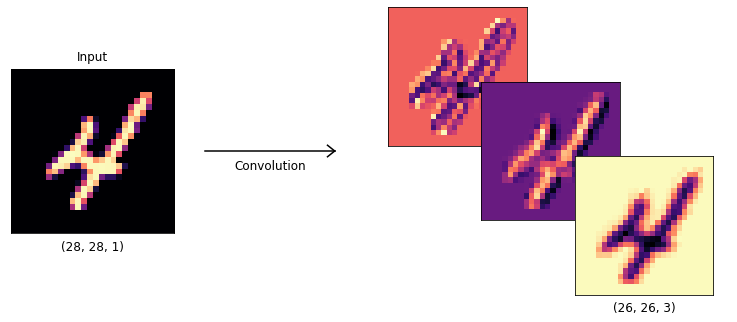

In [7]:
Plot().network(x, [x1])

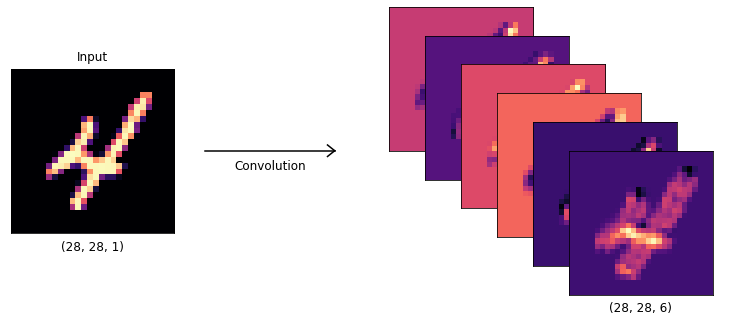

In [8]:
Plot().network(x, [x2])

### Activation Functions

Most CNN architectures also apply an activation function to convolutional layers. We use activation functions to increase non-linearity in the network. In theory, the output layers of convolution with activation have a thresholding effect similar to that of action potentials in the biological firing of neurons.

$$\textsf{input} \ \ \circledast \ \ \text{conv}_{1} \ + \ \text{activation}_1 \ \circledast \ \cdots \ \circledast \ \text{conv}_{N} \ + \ \text{activation}_N \longrightarrow \ \textsf{classification}$$

#### Rectified Linear Unit  (ReLU)
$$f(x) = \begin{cases} 0 & \text{for } x \leq 0 \\
x & \text{for } x > 0 \end{cases}$$

Here we provide an example of convolution with ReLU activation using Keras. Because the Keras library uses *channels last* format (by default) for 2-dimensional convolution, we reload the same MNIST image in the proper format as follows:

In [9]:
x = utils.load_mnist(method='keras', sample=9)

(1, 28, 28, 1)


We create two 2-dimensional convolution objects with ReLU activation, `relu1` and `relu2`, using the Keras function `Conv2D` below. The first convolution object `relu1` uses 3 kernel filters ($K=3$) and no zero padding ($P=0$) of the input border, while `relu2` uses 6 kernel filters ($K=6$) and adds one pixel of zero padding ($P=1$) to the input border. Both convolution objects have kernel size $F=3$ and stride $S=1$ (default). Note that the zero padding parameter is either `'valid'` (default), where $H_\text{out}$ and $W_\text{out}$ are according to equations (2) and (3) with $P=0$, or `'same'`, where $H_\text{out} = H_\text{in}$ and $W_\text{out}=W_\text{in}$.

In [10]:
relu1 = Conv2D(filters=3, kernel_size=3, strides=1, padding='valid',
               activation='relu')
relu2 = Conv2D(filters=6, kernel_size=3, strides=1, padding='same',
               activation='relu')

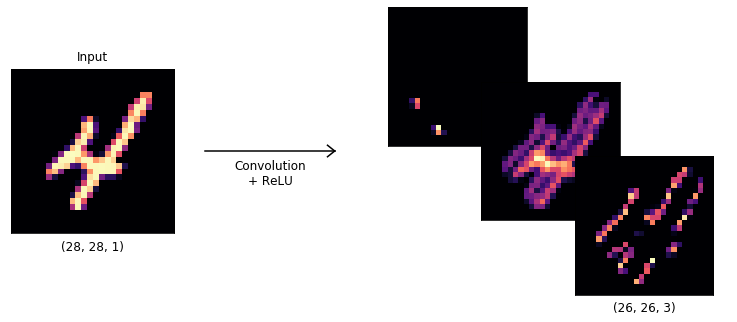

In [11]:
utils.display_conv(x, relu1, activation='ReLU')

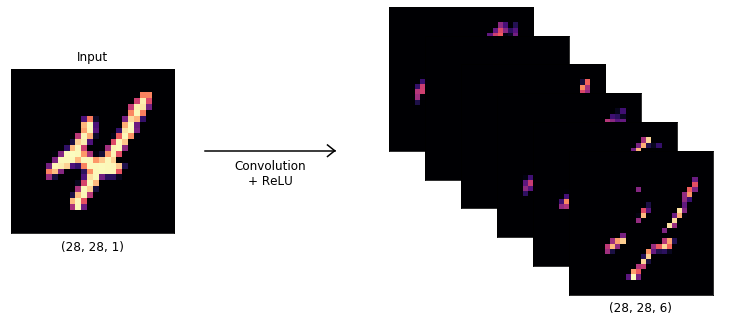

In [12]:
utils.display_conv(x, relu2, activation='ReLU')

#### Softmax
$$P(y=j| \mathbf{x}) = \frac{e^{\mathbf{x}^\mathsf{T}\mathbf{w}_j}}{\sum_{k=1}^{k} e^{\mathbf{x}^\mathsf{T}\mathbf{w}_k}}$$

In [13]:
softmax = Conv2D(filters=3, kernel_size=3, activation='softmax')

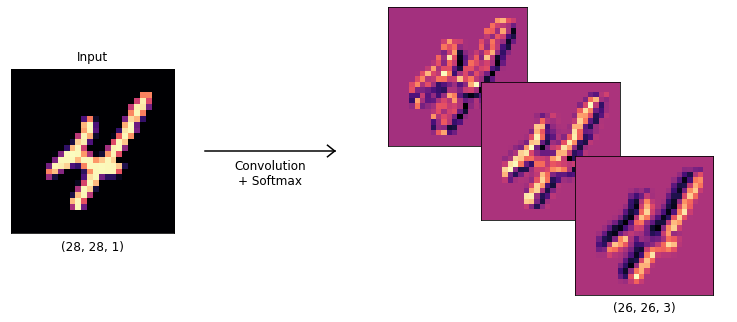

In [14]:
utils.display_conv(x, softmax, activation='Softmax')

#### Sigmoid
$$f(x) = \sigma(x) = \frac{1}{1 + e^{-x}}$$

In [15]:
sigmoid = Conv2D(filters=3, kernel_size=3, activation='sigmoid')

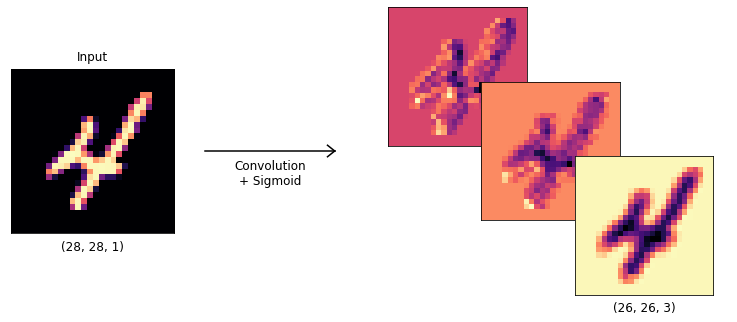

In [16]:
utils.display_conv(x, sigmoid, activation='Sigmoid')

#### Hyperbolic Tangent (tanh)
$$f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

In [17]:
tanh = Conv2D(filters=3, kernel_size=3, activation='tanh')

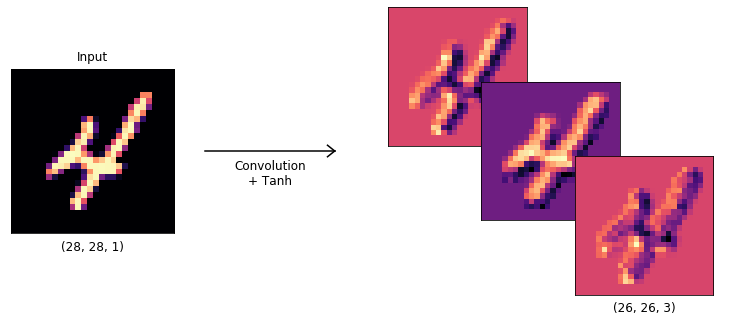

In [18]:
utils.display_conv(x, tanh, activation='Tanh')

#### Exponential Linear Unit (ELU)
$$f(\alpha, x) = \begin{cases} \alpha (e^x - 1) & \text{for } x \leq 0 \\
x & \text{for } x > 0 \end{cases}$$

In [19]:
elu = Conv2D(filters=3, kernel_size=3, activation='elu')

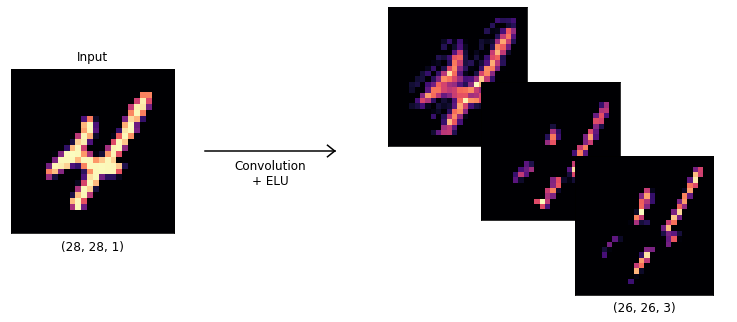

In [20]:
utils.display_conv(x, elu, activation='ELU')

#### Softplus
$$f(x) = \ln(1 + e^x)$$

In [21]:
softplus = Conv2D(filters=3, kernel_size=3, activation='softplus')

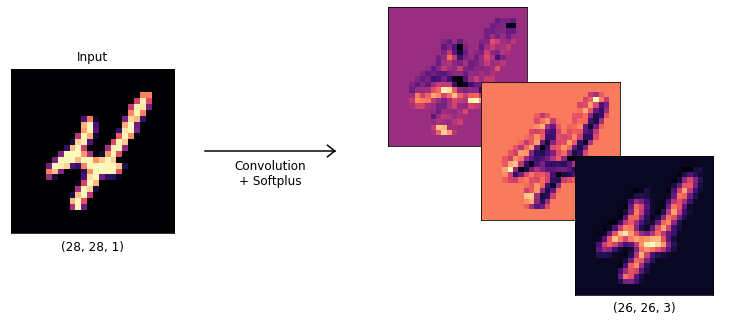

In [22]:
utils.display_conv(x, softplus, activation='Softplus')

#### Softsign
$$f(x) = \frac{x}{1 + |x|}$$

In [23]:
softsign = Conv2D(filters=3, kernel_size=3, activation='softsign')

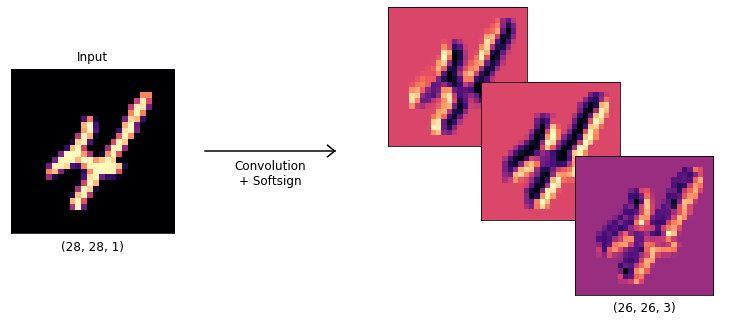

In [24]:
utils.display_conv(x, softsign, activation='Softsign')

#### Others

- Leaky ReLU

- PReLU

- RReLU

- SELU

- GELU

### Pooling

Pooling methods are often used between certain convolutions for dimensionality reduction. The most common method for pooling input layers is *max* pooling using a $2 \times 2$ kernel with non-overlapping strides. In certain cases with very large input, pooling with a $3 \times 3$ kernel may be effective. Typically, *max* pooling produces better results than the less common *average* pooling.

#### Max Pooling

In [25]:
relu = Conv2D(filters=6, kernel_size=3, padding='same', activation='relu')
tanh = Conv2D(filters=6, kernel_size=3, padding='same', activation='tanh')

In [26]:
maxpool = MaxPooling2D(pool_size=(2, 2))

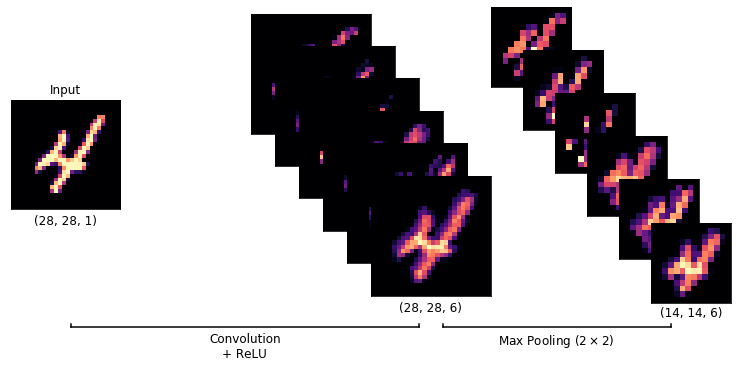

In [27]:
utils.display_conv_pool(x, [relu, maxpool], network_id=0)

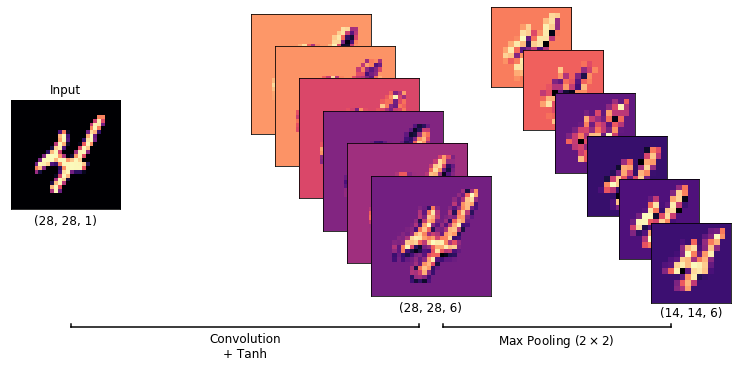

In [28]:
utils.display_conv_pool(x, [tanh, maxpool], network_id=1)

#### Average Pooling

In [29]:
avgpool = AveragePooling2D(pool_size=(2, 2))

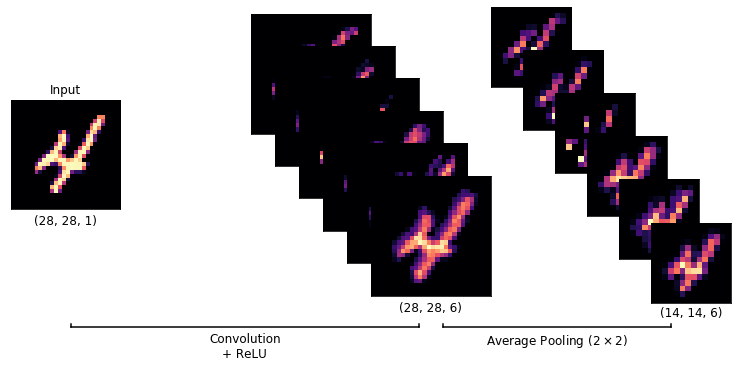

In [30]:
utils.display_conv_pool(x, [relu, avgpool], network_id=2)

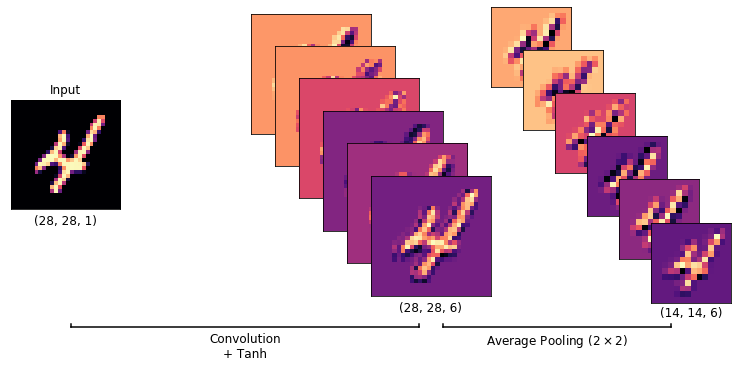

In [31]:
utils.display_conv_pool(x, [tanh, avgpool], network_id=3)

### Adding Layers

In [32]:
relu = Conv2D(filters=6, kernel_size=3, padding='same', activation='relu')
tanh = Conv2D(filters=6, kernel_size=3, padding='same', activation='tanh')

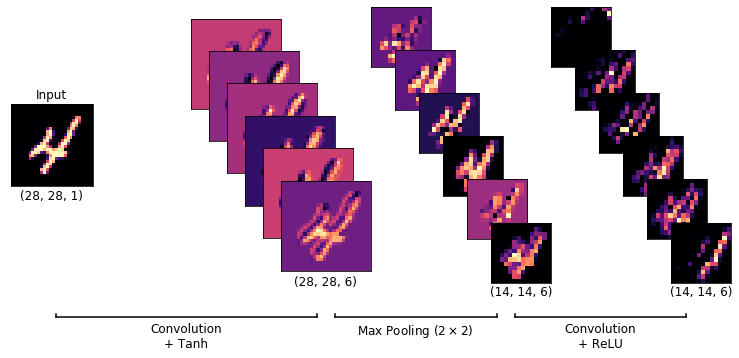

In [33]:
utils.display_conv_pool(x, [tanh, maxpool, relu], network_id=4)

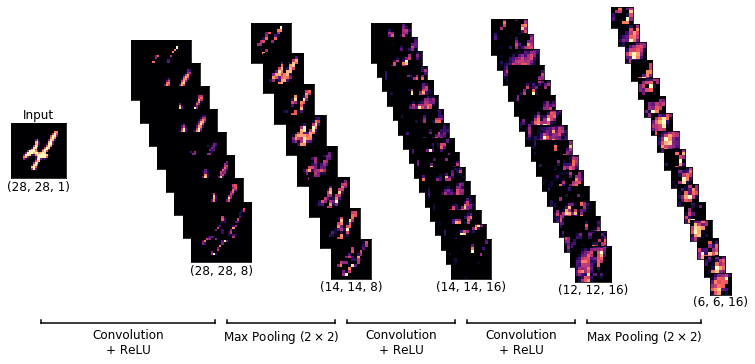

In [34]:
maxpool = MaxPooling2D(pool_size=(2, 2))
relu1 = Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')
relu2 = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')
relu3 = Conv2D(filters=16, kernel_size=3, activation='relu')
utils.display_conv_pool(x, [relu1, maxpool, relu2, relu3, maxpool], network_id=5)

A common CNN feature learning architecture is similar to that shown above, where feature maps are constructed with ReLU-activated convolutional layers and intermittent max pooling. It's also fairly common to normalize the batch of input layers prior to convolution in the feature learning segment.

## Classification

In the classification segment of the network, we flatten the final laywe shift our focus to classification using fully connected (FC) layers.

### Fully Connected (FC) Layers

In [2]:
x_train, y_train, x_test, y_test, input_shape = utils.load_mnist(method='keras')
x_train = K.eval(x_train)
y_train = K.eval(y_train)
x_test = K.eval(x_test)
y_test = K.eval(y_test)

$$\begin{aligned} \underset{30 \times 30 \times 1}{ \ \ \textsf{input}^+} \ \ _{\circledast \ \ \text{conv}_{3 \times 3} \ + \ \text{ReLU} \ \ \longmapsto} \ \ \underset{30 \times 30 \times 32}{ \ \ \textsf{conv1}^+} \ \ _{\circledast \ \ \text{conv}_{3 \times 3} \ + \ \text{ReLU} \ \ \longmapsto} \ \ \underset{28 \times 28 \times 64}{\textsf{conv2}} \ \ _{ \ast \ \ \text{max pool}_{2 \times 2} \ \ \longmapsto}\\[5pt]
\underset{16 \times 16 \times 64}{ \, \ \textsf{pool1}^\ddagger} \ \ _{\circledast \ \ \text{conv}_{3 \times 3} \ + \ \text{ReLU} \ \ \longmapsto} \ \ \underset{14 \times 14 \times 64}{\textsf{conv3}} \ \ _{ \ast \ \ \text{max pool}_{2 \times 2} \ \ \longmapsto} \ \ \underset{8 \times 8 \times 64}{ \, \ \textsf{pool2}^\ddagger} \ \ _{\circledast \ \ \text{conv}_{3 \times 3} \ + \ \text{ReLU} \ \ \longmapsto}\\[5pt]
\underset{7 \times 7 \times 64}{ \, \ \textsf{conv4}^\dagger} \ \ _{\circledast \ \ \text{conv}_{3 \times 3} \ + \ \text{ReLU} \ \ \longmapsto} \ \ \underset{5 \times 5 \times 64}{ \, \ \textsf{conv5}^\dagger} \ \ _{ + \ \ \text{flatten}_{1600} \ + \ \text{dropout}_{0.25} \ + \ \text{dense}_{128} \ + \ \text{ReLU} \ \ \longmapsto}\\[10pt]
\underset{1 \times 1 \times 128}{\textsf{FC6}} \ \ _{ + \ \ \text{dropout}_{0.5} \ + \ \text{dense}_{128} \ + \ \text{ReLU} \ \ \longmapsto} \ \ \underset{1 \times 1 \times 128}{\textsf{FC7}} \ \ _{ + \ \ \text{dropout}_{0.5} \ + \ \text{dense}_{10} \ + \ \text{Softmax} \ \ \longmapsto} \ \ \underset{1 \times 1 \times 10}{\textsf{output}} \end{aligned}$$

Here, we introduce FC layers by building a network beginning with feature learning. We initialize a Keras sequential model object as follows:

In [3]:
model = Sequential()

In [21]:
# from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
# from keras.applications.resnet import ResNet50
# from keras.applications.resnet import ResNet101
# from keras.applications.resnet import ResNet152
# from keras.applications.resnet_v2 import ResNet50V2
# from keras.applications.resnet_v2 import ResNet101V2
# from keras.applications.resnet_v2 import ResNet152V2
# # from keras.applications.resnext import ResNeXt50
# # from keras.applications.resnext import ResNeXt101
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
# from keras.applications.mobilenet_v2 import MobileNetV2
# from keras.applications.densenet import DenseNet121
# from keras.applications.densenet import DenseNet169
# from keras.applications.densenet import DenseNet201
# from keras.applications.nasnet import NASNetLarge
# from keras.applications.nasnet import NASNetMobile
VGG16(weights=None, include_top=True).summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [38]:
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(3, 3)))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(250, activation='sigmoid'))
# model.add(Dense(10, activation='softmax'))
# model.summary()

In [39]:
# model = VGG16(weights=None, include_top=True)
# model.summary()

In [40]:
# model = ResNet50(weights=None, include_top=True)
# model.summary()

In [41]:
# c1 = 32
# c2 = 64
# c3 = 64
# c4 = 64
# c5 = 64

# d1 = 128
# d2 = 128
# d3 = 10
# do1 = 0.25
# do2 = 0.5
# do3 = 0.5

# model = Sequential()
# p = []

# p += [x.shape, np.array(x.shape).prod(), 0]; print(p[-3:])
# model.add(Conv2D(c1, 3, padding='same', activation='relu', input_shape=(28, 28, 1)))
# p += [model(x).shape, np.array(model(x).shape).prod(), 3*3*1*c1]; print(p[-3:])
# model.add(Conv2D(c2, 3, padding='same', activation='relu'))
# p += [model(x).shape, np.array(model(x).shape).prod(), 3*3*c1*c2]; print(p[-3:])
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
# p += [model(x).shape, np.array(model(x).shape).prod(), 0]; print(p[-3:])

# model.add(Conv2D(c3, kernel_size=3, padding='same', activation='relu'))
# p += [model(x).shape, np.array(model(x).shape).prod(), 3*3*c2*c3]; print(p[-3:])
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
# p += [model(x).shape, np.array(model(x).shape).prod(), 0]; print(p[-3:])
# model.add(Conv2D(c4, kernel_size=3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# p += [model(x).shape, np.array(model(x).shape).prod(), 3*3*c3*c4]; print(p[-3:])

# model.add(Conv2D(c5, kernel_size=3, activation='relu'))
# model.add(BatchNormalization())
# p += [model(x).shape, np.array(model(x).shape).prod(), 3*3*c4*c5]; print(p[-3:])
# model.add(Flatten())
# model.add(Dropout(do1))
# model.add(Dense(d1, activation='relu'))
# p += [model(x).shape, np.array(model(x).shape).prod(), 5*5*c5*d1]; print(p[-3:])

# model.add(Dropout(do2))
# model.add(Dense(d2, activation='relu'))
# p += [model(x).shape, np.array(model(x).shape).prod(), d1*d2]; print(p[-3:])
# model.add(Dropout(do3))
# model.add(Dense(d3, activation='softmax'))
# p += [model(x).shape, np.array(model(x).shape).prod(), d2*d3]; print(p[-3:])
# model.summary()

In [42]:
# np.sum(p[2::3])-353354
# np.sum(p[2::3])-352842

Beginning with the architecture

$$\underset{30 \times 30 \times 1}{ \ \ \textsf{input}^+} \ \ _{\circledast \ \ \text{conv}_{3 \times 3} \ + \ \text{ReLU} \ \ \longmapsto} \ \ \underset{30 \times 30 \times 32}{ \ \ \textsf{conv1}^+} \ \ _{\circledast \ \ \text{conv}_{3 \times 3} \ + \ \text{ReLU} \ \ \longmapsto} \ \ \underset{28 \times 28 \times 64}{\textsf{conv2}} \ \ _{ \ast \ \ \text{max pool}_{2 \times 2} \ \ \longmapsto} \ \ \underset{16 \times 16 \times 64}{ \, \ \textsf{pool1}^\ddagger}$$

we add layers as follows:

In [170]:
model = Sequential()

In [171]:
import numpy as np
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

$$\underset{16 \times 16 \times 64}{ \, \ \textsf{pool1}^\ddagger} \ \ _{\circledast \ \ \text{conv}_{3 \times 3} \ + \ \text{ReLU} \ \ \longmapsto} \ \ \underset{14 \times 14 \times 64}{\textsf{conv3}} \ \ _{ \ast \ \ \text{max pool}_{2 \times 2} \ \ \longmapsto} \ \ \underset{8 \times 8 \times 64}{ \, \ \textsf{pool2}^\ddagger} \ \ _{\circledast \ \ \text{conv}_{3 \times 3} \ + \ \text{ReLU} \ \ \longmapsto} \ \ \underset{7 \times 7 \times 64}{ \, \ \textsf{conv4}^\dagger}$$

In [172]:
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
# model.add(BatchNormalization())

Here we switch over to classification by vectorizing `conv5` as follows:

$$\underset{7 \times 7 \times 64}{ \, \ \textsf{conv4}^\dagger} \ \ _{\circledast \ \ \text{conv}_{3 \times 3} \ + \ \text{ReLU} \ \ \longmapsto} \ \ \underset{5 \times 5 \times 64}{ \, \ \textsf{conv5}^\dagger} \ \ _{ + \ \ \text{flatten}_{1600} \ + \ \text{dropout}_{0.25} \ + \ \text{dense}_{156} \ + \ \text{ReLU} \ \ \longmapsto} \ \ \underset{1 \times 1 \times 156}{\textsf{FC6}}$$

In [173]:
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))

$$\underset{1 \times 1 \times 156}{\textsf{FC6}} \ \ _{ + \ \text{dropout}_{0.5} \ + \ \text{dense}_{156} \ + \ \text{ReLU} \ \ \longmapsto} \ \ \underset{1 \times 1 \times 156}{\textsf{FC7}} \ \ _{ + \ \text{dropout}_{0.5} \ + \ \text{dense}_{10} \ + \ \text{Softmax} \ \ \longmapsto} \ \ \underset{1 \times 1 \times 10}{\textsf{output}}$$

In [174]:
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [175]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 7, 7, 32)        

In [176]:
fp = 'models/best_weights.hdf5'
checkpoint = ModelCheckpoint(fp, monitor='val_accuracy', save_best_only=True,
                             save_weights_only=True, mode='max')

In [177]:
model.compile(optimizer='nadam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, callbacks=[checkpoint],
          validation_data=(x_test, y_test), initial_epoch=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
41088/60000 [===================>..........] - ETA: 25s - loss: 0.3894 - accuracy: 0.8858

In [ ]:
model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, callbacks=[checkpoint],
          validation_data=(x_test, y_test), initial_epoch=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10


In [ ]:
model.fit(x_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[checkpoint],
          validation_data=(x_test, y_test), initial_epoch=20)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10


In [169]:
model.load_weights(fp)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06247165977572913
Test accuracy: 0.9829999804496765


In [ ]:
model.load_weights('best_weights.hdf5')

In [53]:
model.fit(x_train[::10], y_train[::10],
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 6000 samples, validate on 10000 samples
Epoch 1/5
6000/6000 [==============================] - 23s 4ms/step - loss: 0.5498 - accuracy: 0.8320 - val_loss: 1.9043 - val_accuracy: 0.9062
Epoch 2/5
6000/6000 [==============================] - 20s 3ms/step - loss: 0.1321 - accuracy: 0.9587 - val_loss: 1.6812 - val_accuracy: 0.9315
Epoch 3/5
6000/6000 [==============================] - 20s 3ms/step - loss: 0.0616 - accuracy: 0.9810 - val_loss: 1.2302 - val_accuracy: 0.9439
Epoch 4/5
6000/6000 [==============================] - 20s 3ms/step - loss: 0.0614 - accuracy: 0.9815 - val_loss: 0.9265 - val_accuracy: 0.9748
Epoch 5/5
6000/6000 [==============================] - 20s 3ms/step - loss: 0.0333 - accuracy: 0.9912 - val_loss: 0.6266 - val_accuracy: 0.9440


In [20]:
model.fit(x_train[::10], y_train[::10],
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 6000 samples, validate on 10000 samples
Epoch 1/5
6000/6000 [==============================] - 20s 3ms/step - loss: 1.7374 - accuracy: 0.3872 - val_loss: 0.5863 - val_accuracy: 0.8070
Epoch 2/5
6000/6000 [==============================] - 19s 3ms/step - loss: 0.7216 - accuracy: 0.7680 - val_loss: 0.2804 - val_accuracy: 0.9217
Epoch 3/5
6000/6000 [==============================] - 20s 3ms/step - loss: 0.4243 - accuracy: 0.8760 - val_loss: 0.2066 - val_accuracy: 0.9355
Epoch 4/5
6000/6000 [==============================] - 20s 3ms/step - loss: 0.3066 - accuracy: 0.9130 - val_loss: 0.1182 - val_accuracy: 0.9670
Epoch 5/5
6000/6000 [==============================] - 20s 3ms/step - loss: 0.2547 - accuracy: 0.9258 - val_loss: 0.0995 - val_accuracy: 0.9668


As shown above, the final fully connected layer `FC3` is vector of length 10. Also note that the number of elements in the final layer should be equal to the number of classes we aim to predict (10 for the MNIST dataset).

INPUT: [224x224x3] memory: 224*224*3=150K params: 0

CONV3-64: [224x224x64] memory: 224*224*64=3.2M params: (3*3*3)*64 = 1,728

CONV3-64: [224x224x64] memory: 224*224*64=3.2M params: (3*3*64)*64 = 36,864

POOL2: [112x112x64] memory: 112*112*64=800K params: 0

CONV3-128: [112x112x128] memory: 112*112*128=1.6M params: (3*3*64)*128 = 73,728

CONV3-128: [112x112x128] memory: 112*112*128=1.6M params: (3*3*128)*128 = 147,456

POOL2: [56x56x128] memory: 56*56*128=400K params: 0

CONV3-256: [56x56x256] memory: 56*56*256=800K params: (3*3*128)*256 = 294,912

CONV3-256: [56x56x256] memory: 56*56*256=800K params: (3*3*256)*256 = 589,824

CONV3-256: [56x56x256] memory: 56*56*256=800K params: (3*3*256)*256 = 589,824

POOL2: [28x28x256] memory: 28*28*256=200K params: 0

CONV3-512: [28x28x512] memory: 28*28*512=400K params: (3*3*256)*512 = 1,179,648

CONV3-512: [28x28x512] memory: 28*28*512=400K params: (3*3*512)*512 = 2,359,296

CONV3-512: [28x28x512] memory: 28*28*512=400K params: (3*3*512)*512 = 2,359,296

POOL2: [14x14x512] memory: 14*14*512=100K params: 0

CONV3-512: [14x14x512] memory: 14*14*512=100K params: (3*3*512)*512 = 2,359,296

CONV3-512: [14x14x512] memory: 14*14*512=100K params: (3*3*512)*512 = 2,359,296

CONV3-512: [14x14x512] memory: 14*14*512=100K params: (3*3*512)*512 = 2,359,296

POOL2: [7x7x512] memory: 7*7*512=25K params: 0

FC: [1x1x4096] memory: 4096 params: 7*7*512*4096 = 102,760,448

FC: [1x1x4096] memory: 4096 params: 4096*4096 = 16,777,216

FC: [1x1x1000] memory: 1000 params: 4096*1000 = 4,096,000


Inception - 22 layers --> 5 million params
AlexNet - 60 million params

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(x, y, validation_split=0.2, callbacks=[early_stopping])

In [125]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=15,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 187s 3ms/step - loss: 0.3284 - accuracy: 0.9037 - val_loss: 0.0919 - val_accuracy: 0.9787
Epoch 2/15
60000/60000 [==============================] - 183s 3ms/step - loss: 0.1043 - accuracy: 0.9749 - val_loss: 0.0379 - val_accuracy: 0.9888
Epoch 3/15
60000/60000 [==============================] - 183s 3ms/step - loss: 0.0719 - accuracy: 0.9825 - val_loss: 0.0594 - val_accuracy: 0.9868
Epoch 4/15
60000/60000 [==============================] - 183s 3ms/step - loss: 0.0576 - accuracy: 0.9865 - val_loss: 0.0324 - val_accuracy: 0.9922
Epoch 5/15
60000/60000 [==============================] - 183s 3ms/step - loss: 0.0491 - accuracy: 0.9883 - val_loss: 0.0255 - val_accuracy: 0.9934
Epoch 6/15
60000/60000 [==============================] - 184s 3ms/step - loss: 0.0430 - accuracy: 0.9907 - val_loss: 0.0296 - val_accuracy: 0.9935
Epoch 7/15
60000/60000 [==============================] - 184s

original

113s 2ms/step - loss: 0.0530 - accuracy: 0.9835 - val_loss: 0.0639 - val_accuracy: 0.9782

115s 2ms/step - loss: 0.0337 - accuracy: 0.9892 - val_loss: 0.0475 - val_accuracy: 0.9870

256

167s 3ms/step - loss: 0.2934 - accuracy: 0.9114 - val_loss: 7.5777 - val_accuracy: 0.1166

161s 3ms/step - loss: 0.0884 - accuracy: 0.9755 - val_loss: 0.0834 - val_accuracy: 0.9783

128

188s 3ms/step - loss: 0.3267 - accuracy: 0.9015 - val_loss: 0.3100 - val_accuracy: 0.9204

183s 3ms/step - loss: 0.1045 - accuracy: 0.9734 - val_loss: 0.0640 - val_accuracy: 0.9855

-1 Dense

186s 3ms/step - loss: 0.1903 - accuracy: 0.9442 - val_loss: 0.1231 - val_accuracy: 0.9664

183s 3ms/step - loss: 0.0677 - accuracy: 0.9806 - val_loss: 0.0415 - val_accuracy: 0.9881

256/128

165s 3ms/step - loss: 0.3505 - accuracy: 0.8961 - val_loss: 1.1719 - val_accuracy: 0.6173

163s 3ms/step - loss: 0.1006 - accuracy: 0.9738 - val_loss: 0.0863 - val_accuracy: 0.9747

512/128

168s 3ms/step - loss: 0.3064 - accuracy: 0.9092 - val_loss: 2.0981 - val_accuracy: 0.2137

164s 3ms/step - loss: 0.0973 - accuracy: 0.9739 - val_loss: 0.1112 - val_accuracy: 0.9668

256 (last dropout)

165s 3ms/step - loss: 0.1644 - accuracy: 0.9507 - val_loss: 1.4443 - val_accuracy: 0.4905

161s 3ms/step - loss: 0.0480 - accuracy: 0.9857 - val_loss: 0.0695 - val_accuracy: 0.9814

256 (last dropout) -1 Dense

166s 3ms/step - loss: 0.1675 - accuracy: 0.9505 - val_loss: 2.0227 - val_accuracy: 0.2638

161s 3ms/step - loss: 0.0551 - accuracy: 0.9838 - val_loss: 0.1623 - val_accuracy: 0.9456


In [39]:
# x_train, y_train, x_test, y_test, input_shape = utils.Load(method='keras').mnist()
# x_train = K.eval(x_train)
# y_train = K.eval(y_train)
# x_test = K.eval(x_test)
# y_test = K.eval(y_test)

from keras.datasets import mnist

batch_size = 128
num_classes = 10
epochs = 2

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


0.25

In [4]:
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(29, 29, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
# utils.fit(model, x_train, y_train, x_test, y_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 6

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/6
 3584/60000 [>.............................] - ETA: 1:16 - loss: 1.3037 - accuracy: 0.5731

KeyboardInterrupt: 

In [51]:
x1 = K.eval(model(x))

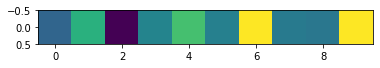

In [52]:
utils.Load(method='torch').mnist(sample=9)

In [45]:
import importlib
importlib.reload(utils)

<module 'src.utils' from '/Users/chadschupbach/projects/personal/mnist/src/utils.py'>

### Dropout

In [87]:
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential

True


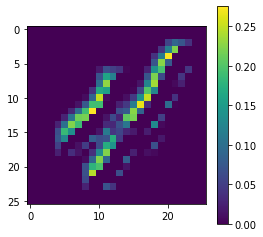

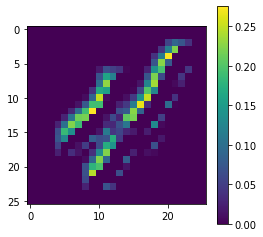

In [1639]:
relu = Conv2D(filters=6, kernel_size=3, activation='relu')
dropout = Dropout(0.5)
x1 = relu(x)
x2 = dropout(x1)
plt.figure(figsize=(4,4))
plt.imshow(K.eval(x1)[0,:,:,0])
plt.colorbar();
plt.figure(figsize=(4,4))
plt.imshow(K.eval(x2)[0,:,:,0])
plt.colorbar();
print(np.allclose(K.eval(x1), K.eval(x2)))
# display_conv_pool(x, , network_id=3)

In [1659]:
model = Sequential()
model.add(Conv2D(filters=3, kernel_size=3, activation='relu'))
x1 = keras.backend.eval(model(x))
print(x1.shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
x2 = keras.backend.eval(model(x))
print(x2.shape)
model.add(Conv2D(filters=6, kernel_size=3, activation='relu'))
x3 = keras.backend.eval(model(x))
print(x3.shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
x4 = keras.backend.eval(model(x))
print(x4.shape)
model.add(Conv2D(filters=6, kernel_size=3, activation='relu'))
x5 = keras.backend.eval(model(x))
print(x5.shape)
model.add(Flatten())
x6 = keras.backend.eval(model(x))
print(x6.shape)
model.add(Dense(32, activation='relu'))
x7 = keras.backend.eval(model(x))
print(x7.shape)

(1, 26, 26, 3)
(1, 13, 13, 3)
(1, 11, 11, 6)
(1, 5, 5, 6)
(1, 3, 3, 6)
(1, 54)
(1, 32)


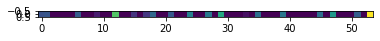

In [1657]:
plt.imshow(x6)

### Loss Layer

### Regularization